# Imported Libraries

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization, LSTM, Input, Reshape 
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import os

# Image Dataset Import

In [2]:
labels = ['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
img_size = 224
def get_data(data_dir):
    data = [] 
    
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                crop_image= img_arr[0:1728,430:2190]
                resized_arr = cv2.resize(crop_image, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
#function call to get_data function that takes file path of the dataset.
data= get_data('dataset/all_equal_300_images/')

<ipython-input-2-b08f5e223f84>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


In [4]:
data.shape

(1200, 2)

In [5]:
type(data)

numpy.ndarray

# Dividing Data Ndarray into Normal, Cataract, Glaucoma and Retina diseases. 

In [6]:
normal= data[0:300]
normal.shape

(300, 2)

In [7]:
cataract=data[300:600]
cataract.shape

(300, 2)

In [8]:
glaucoma= data[600:900]
glaucoma.shape

(300, 2)

In [9]:
retina_disease= data[900:1200]
retina_disease.shape

(300, 2)

In [10]:
random.seed(20)
np.random.shuffle(normal)
np.random.shuffle(cataract)   
np.random.shuffle(glaucoma)
np.random.shuffle(retina_disease)

# Performing Normalization and Resize operation 

In [11]:
def normalize(x_train,x_val,x_test): 
    
    x_train = np.array(x_train) / 255
    x_train.reshape(-1, img_size, img_size, 1)
    
    x_test= np.array(x_test) / 255
    x_test.reshape(-1, img_size, img_size, 1)
    
    x_val= np.array(x_val) / 255
    x_val.reshape(-1, img_size, img_size, 1)
    
        
    return (x_train,x_val,x_test) 

# Separating the Images and Labels into Respective Variables

In [12]:
def image_label_split(train,validation,test):
    
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    x_test = []
    y_test = []

    for feature, label in train:
      x_train.append(feature)
      y_train.append(label)

    for feature, label in validation:
      x_val.append(feature)
      y_val.append(label)


    for feature, label in test:
      x_test.append(feature)
      y_test.append(label)

        
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test= np.array(y_test)
    
    return (x_train,y_train,x_val,y_val,x_test,y_test)


# DenseNet169-LSTM MODEL

In [13]:
def model_build_compile(k):      
    baseModel = DenseNet169(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    for layer in baseModel.layers:
            layer.trainable = False

    x = baseModel.output

        # LSTM layer
    x = Reshape((49, 1664))(x)
    x = ((LSTM(1664, activation="relu", return_sequences=True, trainable=False)))(x)
    x = BatchNormalization()(x)
        

        # FC layer
    x = Flatten(name="flatten")(x)

        # fc1 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)

        # fc2 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)
        

        # Output layer
    output = Dense(units=4, activation='softmax')(x)

    model = Model(inputs=baseModel.input, outputs=output)
    opt = RMSprop(learning_rate=0.01, clipvalue=100)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    k=k+1
    print("model building and compiling for fold",k)
    return model

# Model prediction for Test Images and Computation of Sensitivity and Specificity

In [14]:
def test_pred(x_val,y_val,k):
    predictions = model.predict(x_val)
    predictions = np.argmax(predictions, axis = -1)
    
    print('----------------Test accuracy for',k+1,'fold----------------')
    #Confusion matrix, Accuracy, sensitivity and specificity
    cm1 = confusion_matrix(y_val,predictions)
    print('Confusion Matrix : \n', cm1)

    #####from confusion matrix calculate accuracy
    
    
    sensitivity_1_normal = (cm1[0,0])/(cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[0,3])
    #print('Sensitivity_1_normal          : ', sensitivity_1_normal )

    sensitivity_2_cataract = (cm1[1,1])/(cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[1,3])
    #print('Sensitivity_2_cataract        : ', sensitivity_2_cataract )

    sensitivity_3_glaucoma = (cm1[2,2])/(cm1[2,0]+cm1[2,1]+cm1[2,2]+cm1[2,3])
    #print('Sensitivity_3_glaucoma        : ', sensitivity_3_glaucoma )

    sensitivity_4_retina_disease = (cm1[3,3])/(cm1[3,0]+cm1[3,1]+cm1[3,2]+cm1[3,3])
    #print('Sensitivity_4_retina_disease  : ', sensitivity_4_retina_disease )
    
    specificity_1_normal = (cm1[1,1]+cm1[1,2]+cm1[1,3]+cm1[2,1]+cm1[2,2]+cm1[2,3]+cm1[3,1]+cm1[3,2]+cm1[3,3])/(cm1[1,0]+cm1[2,0]+cm1[3,0]+cm1[1,1]+cm1[1,2]+cm1[1,3]+cm1[2,1]+cm1[2,2]+cm1[2,3]+cm1[3,1]+cm1[3,2]+cm1[3,3])
    #print('Specificity : ', specificity_1_normal)

    specificity_2_cataract = (cm1[0,0]+cm1[0,2]+cm1[0,3]+cm1[2,0]+cm1[2,2]+cm1[2,3]+cm1[3,0]+cm1[3,2]+cm1[3,3])/(cm1[0,1]+cm1[2,1]+cm1[3,1]+cm1[0,0]+cm1[0,2]+cm1[0,3]+cm1[2,0]+cm1[2,2]+cm1[2,3]+cm1[3,0]+cm1[3,2]+cm1[3,3])
    #print('Specificity : ', specificity_2_cataract)

    specificity_3_glaucoma = (cm1[0,0]+cm1[0,1]+cm1[0,3]+cm1[1,0]+cm1[1,1]+cm1[1,3]+cm1[3,0]+cm1[3,1]+cm1[3,3])/(cm1[0,2]+cm1[1,2]+cm1[3,2]+cm1[0,0]+cm1[0,1]+cm1[0,3]+cm1[1,0]+cm1[1,1]+cm1[1,3]+cm1[3,0]+cm1[3,1]+cm1[3,3])
    #print('Specificity : ', specificity_3_glaucoma)

    specificity_4_retina_disease= (cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[2,0]+cm1[2,1]+cm1[2,2])/(cm1[0,3]+cm1[1,3]+cm1[2,3]+cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[2,0]+cm1[2,1]+cm1[2,2])
    #print('Specificity : ', specificity_4_retina_disease)

    Sensitivity= (sensitivity_1_normal + sensitivity_2_cataract + sensitivity_3_glaucoma + sensitivity_4_retina_disease)/4
    #print(Sensitivity)
    
    Specificity= (specificity_1_normal + specificity_2_cataract + specificity_3_glaucoma + specificity_4_retina_disease)/4
    #print(Specificity)
    
    total1=sum(sum(cm1))
    test_accuracy=(cm1[0,0]+cm1[1,1]+cm1[2,2]+cm1[3,3])/total1
    
    print ('Accuracy    : ', test_accuracy)
    print ('Specificity : ', Specificity)
    print ('Sensitivity : ', Sensitivity)
    print('-----------------------------End of',k+1,'Fold--------------------------')
    return test_accuracy,Specificity,Sensitivity,cm1

In [15]:
CM= []
test_accuracy=[]
test_sensitivity=[]
test_specificity=[]
train_acc = []
val_acc = []
train_loss = []
val_loss = []

# DenseNet169-LSTM 5 Fold Cross Validation

In [16]:
for k in range (5): # for loop to run 5 folds 
    n=30  #specifying the number of images for each class in test phase,calulated as per 10% of total images in each class images 300.
    
    
    # Adding the images in normal validation set by using k*n to (k+1)*n as index values for normal dataset divided in cell 6.
    test_normal= normal[k*n:(k+1)*n]
    print('------------------------Start of',k+1,'Fold------------------------')
    print('test images for normal class from',k*n,(k+1)*n)
    
    # Adding the images in cataract validation set by using k*n to (k+1)*nas index values for cataract dataset divided in cell 7.
    test_cataract= cataract[k*n:(k+1)*n]
    print('test images for cataract class from',k*n,(k+1)*n)
    
    # Adding the images in gluacoma validation set by using k*nto (k+1)*n as index values for gluacoma dataset divided in cell 8.
    test_glaucoma= glaucoma[k*n:(k+1)*n]
    print('test images for glaucoma class from',k*n,(k+1)*n)
    
    # Adding the images in retina disease validation set by using k*n to (k+1)*n as index values for retina disease dataset divided in cell 9.
    test_retina= retina_disease[k*n:(k+1)*n]
    print('test images for retina disease class from',k*n,(k+1)*n)
    
    # Now for train and validation set of Normal images first adding 0 to k*n images and then adding all the images from (k+1)*n till last image. 
    
    train_validation_normal= normal[:k*n] 
    train_validation_normal= np.append(train_validation_normal,normal[(k+1)*n:],axis=0)
    print('train_validation images for normal class from 0 to',k*n,'and',(k+1)*n,'to 300')
    
    # Now for train and validation set of cataract images first adding 0 to k*n images and then adding all the images from (k+1)*n till last image. 
    
    train_validation_cataract= cataract[:k*n] 
    train_validation_cataract= np.append(train_validation_cataract,cataract[(k+1)*n:],axis=0)
    print('train_validation images for cataract class from 0 to',k*n,'and',(k+1)*n,'to 300')

    # Now for train and validation set of glaucoma images first adding 0 to k*n images and then adding all the images from (k+1)*n till last image. 

    train_validation_glaucoma= glaucoma[:k*n] 
    train_validation_glaucoma= np.append(train_validation_glaucoma,glaucoma[(k+1)*n:],axis=0)
    print('train_validation  images for glaucoma class from 0',k*n,'and',(k+1)*n,'to 300')
    
    # Now for train and validation set of retina disease images first adding 0 to k*n images and then adding all the images from (k+1)*n till last image. 

    train_validation_retina= retina_disease[:k*n] 
    train_validation_retina= np.append(train_validation_retina,retina_disease[(k+1)*n:],axis=0)
    print('train_validation images for retina disease class from 0 to',k*n,'and',(k+1)*n,'to 300')
    
    
    
    # Splitting the train validation datasets in 80:20 ratio which would eventually give us 70% images in train and 20% images in validation and 10% in test.

    normal_train, normal_validation                 = train_test_split(train_validation_normal, test_size=0.20, random_state=14,shuffle=True)
    cataract_train, cataract_validation             = train_test_split(train_validation_cataract, test_size=0.20, random_state=14,shuffle=True)
    glaucoma_train, glaucoma_validation             = train_test_split(train_validation_glaucoma, test_size=0.20, random_state=14,shuffle=True)
    retina_disease_train, retina_disease_validation = train_test_split(train_validation_retina, test_size=0.20, random_state=14,shuffle=True)

    # Appending all train set images for all classes
    train= np.append(normal_train,cataract_train,axis=0)
    train= np.append(train,glaucoma_train,axis=0)
    train= np.append(train,retina_disease_train,axis=0)

    # Appending all validation set images for all classes
    validation= np.append(normal_validation,cataract_validation,axis=0)
    validation= np.append(validation,glaucoma_validation,axis=0)
    validation= np.append(validation,retina_disease_validation,axis=0)
    
    # Appending all test set images for all classes
    test= np.append(test_normal,test_cataract,axis=0)
    test= np.append(test,test_glaucoma,axis=0)
    test= np.append(test,test_retina,axis=0)    
    

    # Shuffling the train validation and test set as they are added sequentially. 
    random.seed(6)
    np.random.shuffle(train)
    np.random.shuffle(validation)   
    np.random.shuffle(test)
 
    
    # Passing the train validation test as argument for image_label_split function that return features and labels separated.
    x_train,y_train,x_val,y_val,x_test,y_test = image_label_split(train,validation,test)
    
    # Passing the x_Train x_val and x_test as a argument for normalize function that returns the normalized and reshaped sets.
    x_train,x_val,x_test = normalize(x_train,x_val,x_test)
    
    # model building and model compile is done using a model_build_compile(). 
    
    model = model_build_compile(k)
    
    history = model.fit(x_train,y_train,epochs =50, validation_data = (x_val,y_val))
    

    train_acc = np.append(train_acc,history.history['accuracy'])
    val_acc = np.append(val_acc,history.history['val_accuracy'])
    
    train_loss = np.append(train_loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
                        
    x,y,z,c = test_pred(x_test,y_test,k)
    

    CM.append([c])
    test_accuracy.append(x)
    test_specificity.append(y)
    test_sensitivity.append(z)

    

------------------------Start of 1 Fold------------------------
test images for normal class from 0 30
test images for cataract class from 0 30
test images for glaucoma class from 0 30
test images for retina disease class from 0 30
train_validation images for normal class from 0 to 0 and 30 to 300
train_validation images for cataract class from 0 to 0 and 30 to 300
train_validation  images for glaucoma class from 0 0 and 30 to 300
train_validation images for retina disease class from 0 to 0 and 30 to 300
model building and compiling for fold 1
Epoch 1/50
27/27 [==============================] - 214s 8s/step - loss: 11.7136 - accuracy: 0.5058 - val_loss: 24.5036 - val_accuracy: 0.4306
Epoch 2/50
27/27 [==============================] - 218s 8s/step - loss: 6.3867 - accuracy: 0.5706 - val_loss: 13.7179 - val_accuracy: 0.4537
Epoch 3/50
27/27 [==============================] - 221s 8s/step - loss: 3.5130 - accuracy: 0.6181 - val_loss: 11.5519 - val_accuracy: 0.2778
Epoch 4/50
27/27 [=====

model building and compiling for fold 2
Epoch 1/50
27/27 [==============================] - 251s 9s/step - loss: 12.5064 - accuracy: 0.5023 - val_loss: 15.9334 - val_accuracy: 0.3148
Epoch 2/50
27/27 [==============================] - 224s 8s/step - loss: 5.0495 - accuracy: 0.5301 - val_loss: 5.1200 - val_accuracy: 0.5093
Epoch 3/50
27/27 [==============================] - 224s 8s/step - loss: 3.1115 - accuracy: 0.6273 - val_loss: 7.5052 - val_accuracy: 0.3056
Epoch 4/50
27/27 [==============================] - 223s 8s/step - loss: 1.9022 - accuracy: 0.6574 - val_loss: 3.8409 - val_accuracy: 0.3889
Epoch 5/50
27/27 [==============================] - 222s 8s/step - loss: 1.6997 - accuracy: 0.7060 - val_loss: 4.8268 - val_accuracy: 0.5185
Epoch 6/50
27/27 [==============================] - 223s 8s/step - loss: 1.0343 - accuracy: 0.7975 - val_loss: 7.8802 - val_accuracy: 0.3380
Epoch 7/50
27/27 [==============================] - 225s 8s/step - loss: 1.0928 - accuracy: 0.8368 - val_loss: 2

27/27 [==============================] - 230s 8s/step - loss: 5.5078 - accuracy: 0.5660 - val_loss: 13.3359 - val_accuracy: 0.3704
Epoch 3/50
27/27 [==============================] - 227s 8s/step - loss: 2.9738 - accuracy: 0.6447 - val_loss: 14.5456 - val_accuracy: 0.2963
Epoch 4/50
27/27 [==============================] - 226s 8s/step - loss: 1.7947 - accuracy: 0.6481 - val_loss: 8.0374 - val_accuracy: 0.3333
Epoch 5/50
27/27 [==============================] - 244s 9s/step - loss: 1.4656 - accuracy: 0.7199 - val_loss: 9.2674 - val_accuracy: 0.3056
Epoch 6/50
27/27 [==============================] - 235s 9s/step - loss: 1.3223 - accuracy: 0.7512 - val_loss: 10.6677 - val_accuracy: 0.3426
Epoch 7/50
27/27 [==============================] - 231s 9s/step - loss: 0.6510 - accuracy: 0.8345 - val_loss: 7.9405 - val_accuracy: 0.3750
Epoch 8/50
27/27 [==============================] - 230s 9s/step - loss: 0.5879 - accuracy: 0.8785 - val_loss: 12.4358 - val_accuracy: 0.2917
Epoch 9/50
27/27 [==

27/27 [==============================] - 247s 9s/step - loss: 2.9848 - accuracy: 0.6250 - val_loss: 11.9622 - val_accuracy: 0.3519
Epoch 4/50
27/27 [==============================] - 244s 9s/step - loss: 1.7517 - accuracy: 0.6562 - val_loss: 9.4896 - val_accuracy: 0.3287
Epoch 5/50
27/27 [==============================] - 239s 9s/step - loss: 1.5434 - accuracy: 0.7269 - val_loss: 7.4874 - val_accuracy: 0.3889
Epoch 6/50
27/27 [==============================] - 238s 9s/step - loss: 1.1456 - accuracy: 0.7674 - val_loss: 11.1404 - val_accuracy: 0.2917
Epoch 7/50
27/27 [==============================] - 242s 9s/step - loss: 0.6893 - accuracy: 0.8079 - val_loss: 4.0957 - val_accuracy: 0.5046
Epoch 8/50
27/27 [==============================] - 235s 9s/step - loss: 0.4084 - accuracy: 0.8843 - val_loss: 3.0095 - val_accuracy: 0.5370
Epoch 9/50
27/27 [==============================] - 232s 9s/step - loss: 0.4869 - accuracy: 0.8785 - val_loss: 10.0974 - val_accuracy: 0.3750
Epoch 10/50
27/27 [==

27/27 [==============================] - 241s 9s/step - loss: 2.7039 - accuracy: 0.6366 - val_loss: 7.7214 - val_accuracy: 0.3796
Epoch 5/50
27/27 [==============================] - 243s 9s/step - loss: 1.4764 - accuracy: 0.7315 - val_loss: 17.6622 - val_accuracy: 0.3009
Epoch 6/50
27/27 [==============================] - 245s 9s/step - loss: 0.9311 - accuracy: 0.7766 - val_loss: 8.8572 - val_accuracy: 0.3102
Epoch 7/50
27/27 [==============================] - 244s 9s/step - loss: 1.1029 - accuracy: 0.7882 - val_loss: 4.9625 - val_accuracy: 0.4769
Epoch 8/50
27/27 [==============================] - 243s 9s/step - loss: 0.5588 - accuracy: 0.8692 - val_loss: 3.8356 - val_accuracy: 0.5509
Epoch 9/50
27/27 [==============================] - 242s 9s/step - loss: 0.4421 - accuracy: 0.8958 - val_loss: 7.4948 - val_accuracy: 0.4120
Epoch 10/50
27/27 [==============================] - 242s 9s/step - loss: 0.3168 - accuracy: 0.9190 - val_loss: 6.6234 - val_accuracy: 0.5278
Epoch 11/50
27/27 [===

# Test Evaluation Results

In [17]:
test_accuracy

[0.6833333333333333,
 0.65,
 0.7416666666666667,
 0.7333333333333333,
 0.6666666666666666]

In [18]:
mean_test_accuracy=np.mean(test_accuracy)
mean_test_accuracy

0.6950000000000001

In [19]:
test_sensitivity

[0.6833333333333333,
 0.6499999999999999,
 0.7416666666666666,
 0.7333333333333334,
 0.6666666666666666]

In [20]:
mean_test_sensitivity= np.mean(test_sensitivity)
mean_test_sensitivity

0.695

In [21]:
test_specificity

[0.8683632583623587,
 0.8656207246568692,
 0.897321786795471,
 0.8898720285099685,
 0.8667540792540793]

In [22]:
mean_test_specificity= np.mean(test_specificity)
mean_test_specificity

0.8775863755157495

# Training and Validation Evaluation Results

In [23]:
train_acc

array([0.50578701, 0.57060188, 0.61805558, 0.67939812, 0.71643519,
       0.7650463 , 0.8275463 , 0.85416669, 0.90856481, 0.87731481,
       0.8912037 , 0.9224537 , 0.9375    , 0.93981481, 0.95949072,
       0.9386574 , 0.96875   , 0.95717591, 0.96064812, 0.9548611 ,
       0.96527779, 0.97337961, 0.97800928, 0.96875   , 0.9849537 ,
       0.96527779, 0.97916669, 0.98148149, 0.97569442, 0.9849537 ,
       0.9849537 , 0.97685188, 0.99537039, 0.97685188, 0.97800928,
       0.98958331, 0.98148149, 0.9849537 , 0.97916669, 0.9861111 ,
       0.9861111 , 0.98726851, 0.98958331, 0.99305558, 0.98842591,
       0.99305558, 0.98032409, 0.99652779, 0.97916669, 0.99537039,
       0.50231481, 0.5300926 , 0.62731481, 0.6574074 , 0.70601851,
       0.7974537 , 0.83680558, 0.8761574 , 0.91203701, 0.90972221,
       0.91898149, 0.92824072, 0.92592591, 0.93055558, 0.9548611 ,
       0.94791669, 0.96064812, 0.96296299, 0.9699074 , 0.96180558,
       0.9548611 , 0.97106481, 0.97800928, 0.96296299, 0.97337

In [24]:
mean_train_accuracy=np.mean(train_acc)
mean_train_accuracy

0.9257037023305893

In [25]:
val_acc

array([0.43055555, 0.4537037 , 0.27777779, 0.35648149, 0.29166666,
       0.3287037 , 0.38425925, 0.40277779, 0.41666666, 0.5       ,
       0.3425926 , 0.63425928, 0.68518519, 0.58796299, 0.46296296,
       0.56018519, 0.60185188, 0.56481481, 0.55555558, 0.63425928,
       0.6574074 , 0.68055558, 0.68518519, 0.72222221, 0.70833331,
       0.67592591, 0.7361111 , 0.64351851, 0.72685188, 0.66666669,
       0.7037037 , 0.68981481, 0.75      , 0.75462961, 0.74537039,
       0.5462963 , 0.67592591, 0.625     , 0.66666669, 0.6574074 ,
       0.69444442, 0.6712963 , 0.72222221, 0.6388889 , 0.67592591,
       0.6574074 , 0.67592591, 0.68055558, 0.7175926 , 0.68518519,
       0.31481481, 0.50925928, 0.30555555, 0.3888889 , 0.51851851,
       0.33796296, 0.25925925, 0.3888889 , 0.43055555, 0.5462963 ,
       0.31018519, 0.59722221, 0.49537036, 0.6712963 , 0.51851851,
       0.47222221, 0.60648149, 0.51851851, 0.56481481, 0.63425928,
       0.60648149, 0.7037037 , 0.49537036, 0.62037039, 0.74537

In [26]:
mean_val_accuracy=np.mean(val_acc)
mean_val_accuracy

0.6004074078798294

In [27]:
train_loss

array([1.17135706e+01, 6.38666487e+00, 3.51297641e+00, 1.91685009e+00,
       1.95859861e+00, 1.22591114e+00, 7.20051944e-01, 5.74148059e-01,
       3.54200631e-01, 4.61351037e-01, 5.35433471e-01, 3.91402036e-01,
       2.80295163e-01, 2.34892085e-01, 2.07070097e-01, 2.97496468e-01,
       1.41313627e-01, 2.05331132e-01, 1.74335599e-01, 1.88435853e-01,
       1.88248426e-01, 8.82019177e-02, 1.11027174e-01, 1.38275594e-01,
       4.23851572e-02, 1.15716495e-01, 7.96397701e-02, 6.15428723e-02,
       1.24747530e-01, 7.20200166e-02, 6.96803257e-02, 1.10577710e-01,
       1.76808331e-02, 9.75238383e-02, 8.64869505e-02, 3.08388099e-02,
       8.33916217e-02, 4.85222042e-02, 7.28347898e-02, 8.60523358e-02,
       3.73556577e-02, 3.38391699e-02, 4.93248478e-02, 2.62614861e-02,
       4.15797979e-02, 3.14575620e-02, 1.00816682e-01, 4.99448366e-03,
       9.07085091e-02, 2.97741797e-02, 1.25063944e+01, 5.04951572e+00,
       3.11151075e+00, 1.90221035e+00, 1.69968474e+00, 1.03428662e+00,
      

In [28]:
mean_train_loss=np.mean(train_loss)
mean_train_loss

0.6478431741381064

In [29]:
val_loss

array([ 24.50358582,  13.71792221,  11.55187416,   5.78467035,
        11.5177536 ,   7.19924498,   3.2643404 ,   6.41444492,
         5.4908638 ,   3.70043039,  14.09852791,   3.17769504,
         2.52124977,   3.26490426,   5.47941875,   4.40330744,
         3.99522543,   3.74482274,  12.00065804,  23.05793571,
         5.07710314,   4.62481117,   2.98224735,   4.70060396,
         6.02304125,   3.55785871,   6.24872208,   5.19193745,
         5.62975073,   9.23026657,   8.85900688,  12.17224121,
         2.76951289,   9.44723701,   6.0042491 , 280.5748291 ,
        11.35315132,  27.47146988,  34.02479935,  41.93907928,
       112.55037689, 223.75364685,  77.08407593,   7.10890818,
       138.35705566, 428.39321899,   6.01841545,  10.13053417,
       125.8059082 , 239.83030701,  15.93342113,   5.11999416,
         7.50522423,   3.84086919,   4.82679701,   7.88022852,
        20.66157722,   7.17051458,   7.37955523,   4.15494013,
         9.65765285,   3.79697704,   5.76285458,   3.35

In [30]:
mean_val_loss=np.mean(val_loss)
mean_val_loss

14.016397735118867

# Plot to Visualize the Number of Images in Each Label of Trainig Dataset

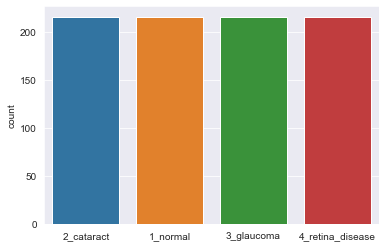

In [31]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l)

# Plot to Visualize the Number of Images in Each Label of Test Dataset.

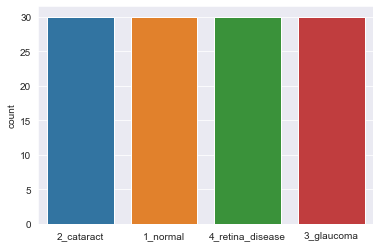

In [32]:
l = []
for i in test:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l)

# Plot to Visualize the Number of Images in Each Label of Validation Dataset.

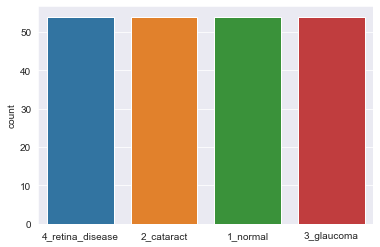

In [33]:
l = []
for i in validation:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l)

# Training,Validation Accuracy and Loss Plot for 50 Epochs

In [34]:
def plot_print(i,j):
    epochs_range = range(50)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_acc[i:j], label='Training Accuracy')
    plt.plot(epochs_range, val_acc[i:j], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, train_loss[i:j], label='Training Loss')
    plt.plot(epochs_range, val_loss[i:j], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    return plt.show()

Plot for  1 cross validation accuracy and loss for Training and Validation phase


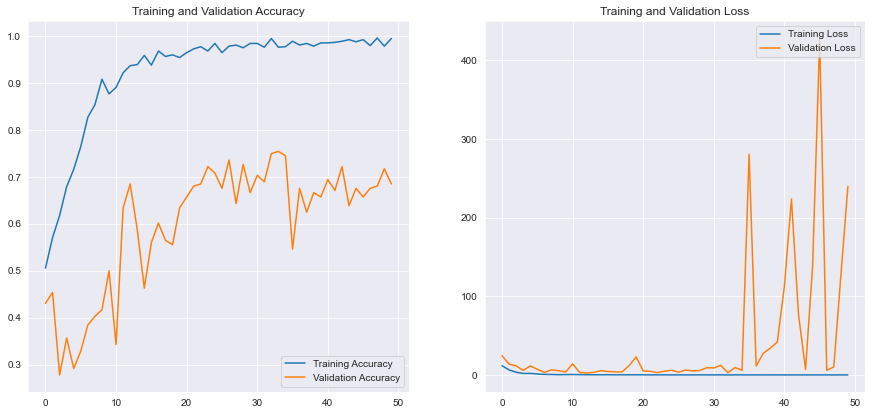

Plot for  2 cross validation accuracy and loss for Training and Validation phase


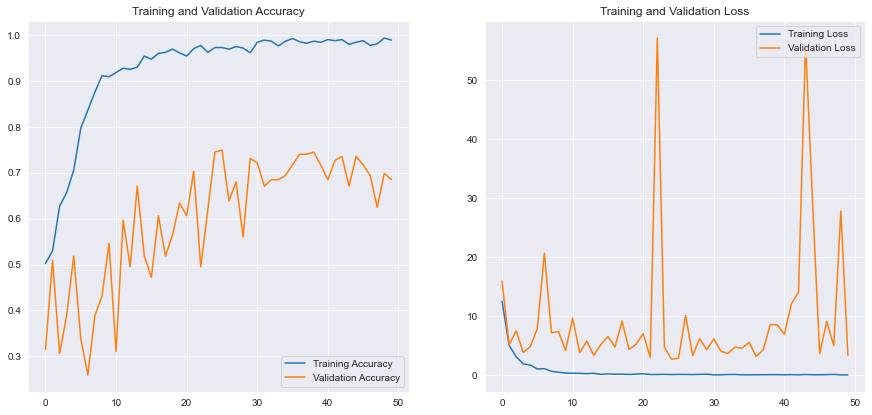

Plot for  3 cross validation accuracy and loss for Training and Validation phase


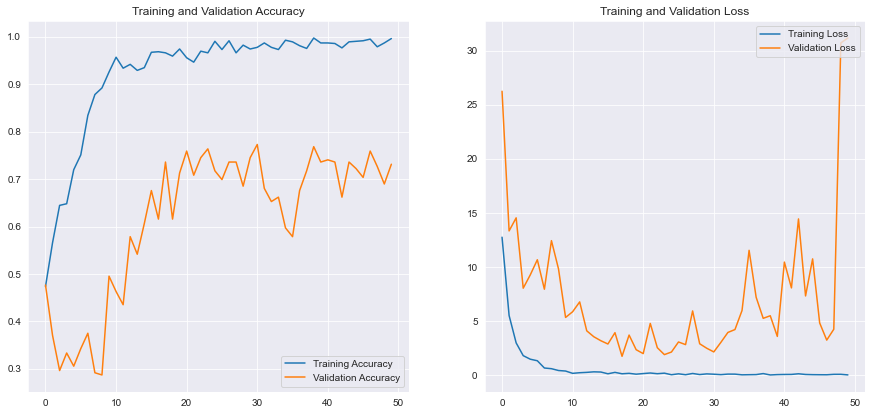

Plot for  4 cross validation accuracy and loss for Training and Validation phase


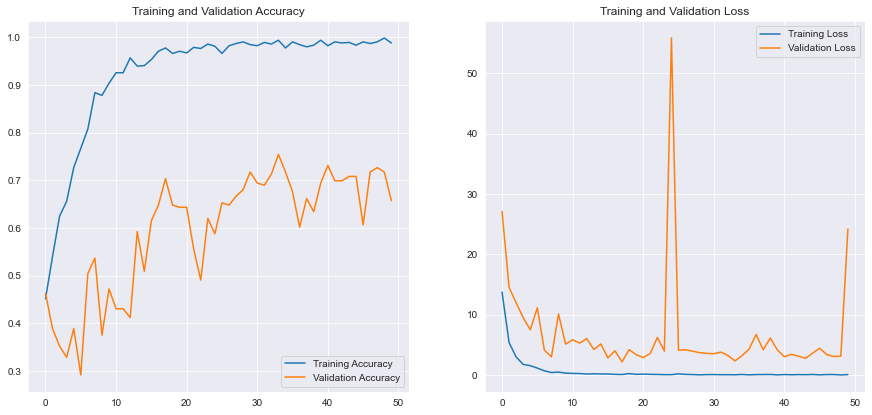

Plot for  5 cross validation accuracy and loss for Training and Validation phase


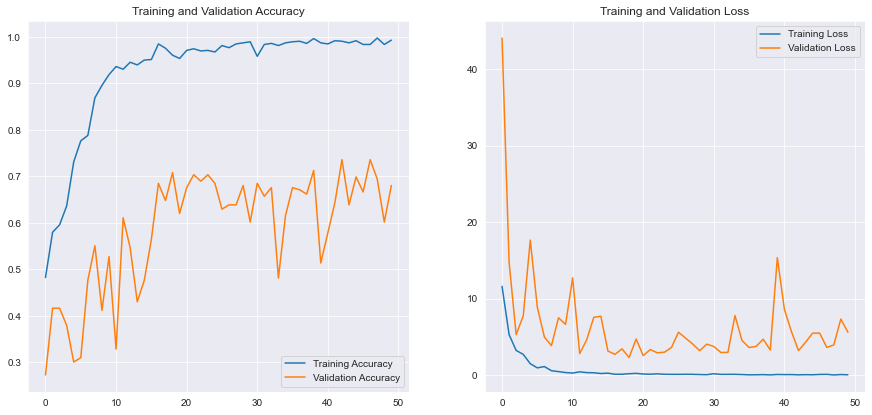

In [35]:
k=1
j=0
for i in range(0,250,50):
    j +=50
    print('Plot for ',k,'cross validation accuracy and loss for Training and Validation phase')
    k +=1
    plot_print(i,j)


# Visualizing Confusion Matrix for Each Fold

In [36]:
CM= np.array(CM)
CM.resize(5,4,4)

In [37]:
def confusionmatrix_vis(i):

        yticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
        xticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
        plt.figure(figsize=(8, 8))
        hm =sns.heatmap(CM[i], annot=True,annot_kws={"size": 20}, cbar=False,cmap="YlGnBu",yticklabels=yticklabels,xticklabels=xticklabels)

        hm.set_xticklabels(hm.get_xticklabels(), rotation=0, fontsize = 12, ) 
        hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize = 12) 

        plt.ylabel("Actual", fontsize = 18)
        plt.xlabel("Predicted",fontsize = 18)
      
        return plt.show()

Confusion Matrix for  1 Cross Validation Test phase


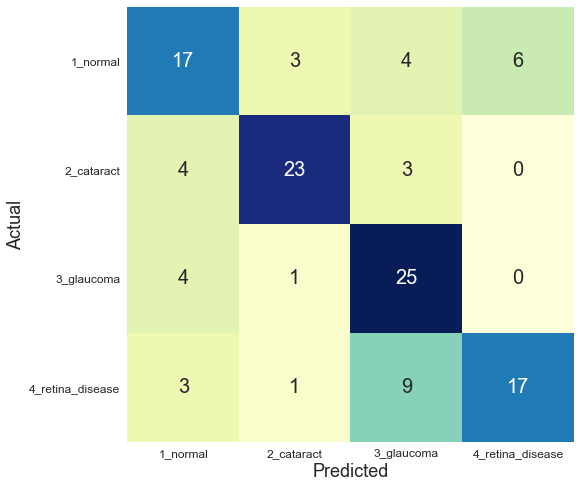

Confusion Matrix for  2 Cross Validation Test phase


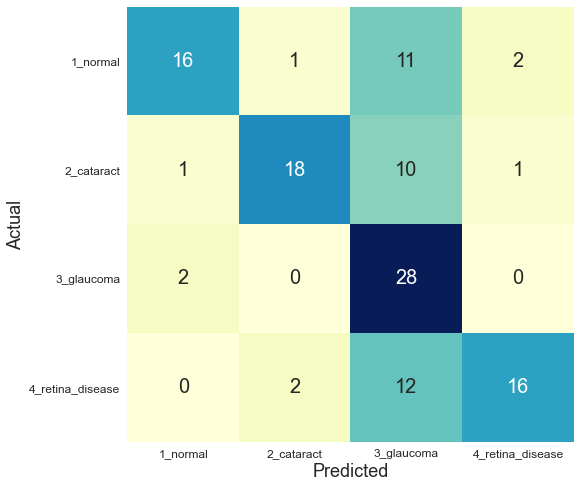

Confusion Matrix for  3 Cross Validation Test phase


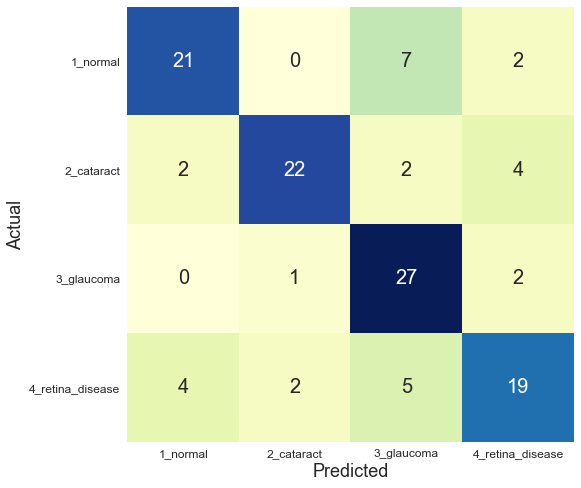

Confusion Matrix for  4 Cross Validation Test phase


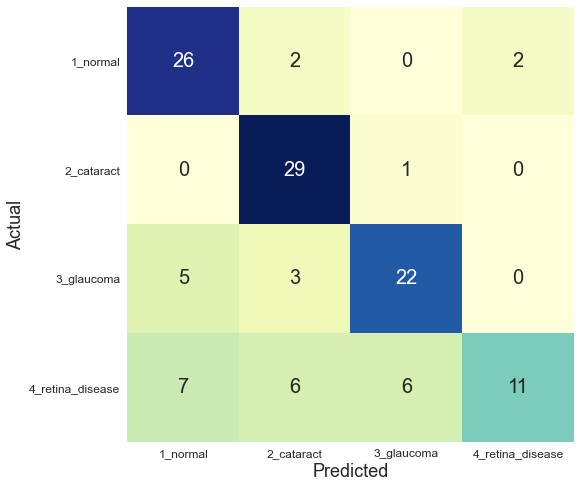

Confusion Matrix for  5 Cross Validation Test phase


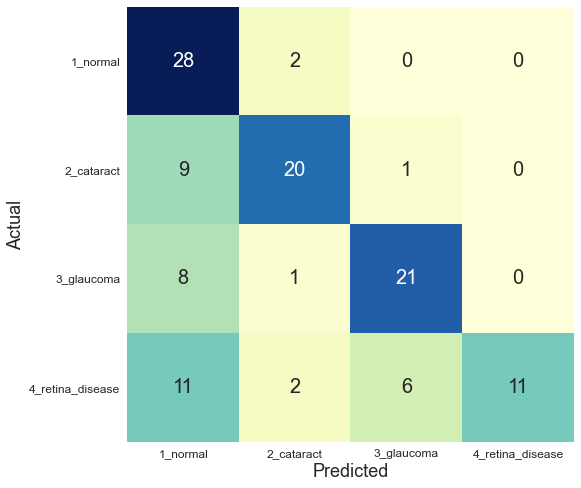

In [38]:
k=1
for i in range(5):    
    print('Confusion Matrix for ',k,'Cross Validation Test phase')
    k +=1
    confusionmatrix_vis(i)


# Visualizing Summarized Confusion Matrix of all 5 folds

In [39]:
CM_sum = CM[0]+CM[1]+CM[2]+CM[3]+CM[4]
CM_sum

array([[108,   8,  22,  12],
       [ 16, 112,  17,   5],
       [ 19,   6, 123,   2],
       [ 25,  13,  38,  74]], dtype=int64)

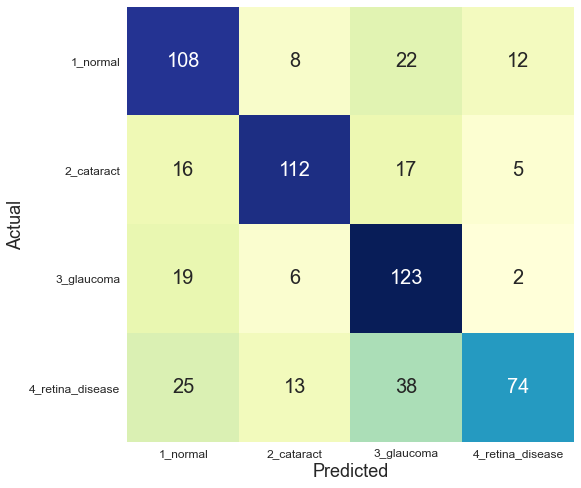

In [40]:
yticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
xticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
plt.figure(figsize=(8, 8))
hm =sns.heatmap(CM_sum, annot=True,annot_kws={"size": 20},fmt='g', cbar=False,cmap="YlGnBu",yticklabels=yticklabels,xticklabels=xticklabels)

hm.set_xticklabels(hm.get_xticklabels(), rotation=0, fontsize = 12, ) 
hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize = 12) 

plt.ylabel("Actual", fontsize = 18)
plt.xlabel("Predicted",fontsize = 18)
      
plt.show()

# Reconfirming the values of Accuracy,Sensitivity and Specificity

In [41]:
    sensitivity_1_normal = (CM_sum[0,0])/(CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[0,3])
    #print('Sensitivity_1_normal          : ', sensitivity_1_normal )

    sensitivity_2_cataract = (CM_sum[1,1])/(CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3])
    #print('Sensitivity_2_cataract        : ', sensitivity_2_cataract )


    sensitivity_3_glaucoma = (CM_sum[2,2])/(CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3])
    #print('Sensitivity_3_glaucoma        : ', sensitivity_3_glaucoma )

    sensitivity_4_retina_disease = (CM_sum[3,3])/(CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])
    #print('Sensitivity_4_retina_disease  : ', sensitivity_4_retina_disease )
    
    specificity_1_normal = (CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])/(CM_sum[1,0]+CM_sum[2,0]+CM_sum[3,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])
    #print('Specificity : ', specificity_1_normal)

    specificity_2_cataract = (CM_sum[0,0]+CM_sum[0,2]+CM_sum[0,3]+CM_sum[2,0]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,0]+CM_sum[3,2]+CM_sum[3,3])/(CM_sum[0,1]+CM_sum[2,1]+CM_sum[3,1]+CM_sum[0,0]+CM_sum[0,2]+CM_sum[0,3]+CM_sum[2,0]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,0]+CM_sum[3,2]+CM_sum[3,3])
    #print('Specificity : ', specificity_2_cataract)

    specificity_3_glaucoma = (CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,3]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,3]+CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,3])/(CM_sum[0,2]+CM_sum[1,2]+CM_sum[3,2]+CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,3]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,3]+CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,3])
    #print('Specificity : ', specificity_3_glaucoma)

    specificity_4_retina_disease= (CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2])/(CM_sum[0,3]+CM_sum[1,3]+CM_sum[2,3]+CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2])
    #print('Specificity : ', specificity_4_retina_disease)

    Sensitivity= (sensitivity_1_normal + sensitivity_2_cataract + sensitivity_3_glaucoma + sensitivity_4_retina_disease)/4
    #print(Sensitivity)
    
    Specificity= (specificity_1_normal + specificity_2_cataract + specificity_3_glaucoma + specificity_4_retina_disease)/4
    #print(Specificity)
    
    total1=sum(sum(CM_sum))
    test_accuracy=(CM_sum[0,0]+CM_sum[1,1]+CM_sum[2,2]+CM_sum[3,3])/total1
    
    print ('Accuracy    : ', test_accuracy)
    print ('Specificity : ', Specificity)
    print ('Sensitivity : ', Sensitivity)

Accuracy    :  0.695
Specificity :  0.874009928780574
Sensitivity :  0.695


# Model Summary

In [42]:
model_build_compile(k)

model building and compiling for fold 7


In [43]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________